Install required packages

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 101.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 KB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 52.1 MB/s eta 0:00:00


Import libraries

In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertModel
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

Load the saved model

In [13]:
PATH = '/content/drive/MyDrive/School/ITS 490 Research Project/Models/Original, Good Weights (Pre ChatGPT)/bertNewsClassifier2.pth'
#PATH = '/content/drive/MyDrive/School/ITS 490 Research Project/Model/Weights/bertNewsClassifier3_model.pth'

model = torch.load(PATH)
model.eval()

FileNotFoundError: ignored

## **Utility Functions**

In [14]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
real_count = 0
fake_count = 0
test_labels = np.zeros(119)
pred_labels = []

def preprocess_text(text):
    parts = []

    text_len = len(text.split(' '))
    delta = 300
    max_parts = 5
    nb_cuts = int(text_len / delta)
    nb_cuts = min(nb_cuts, max_parts)
    
    for i in range(nb_cuts + 1):
        text_part = ' '.join(text.split(' ')[i * delta: (i + 1) * delta])
        parts.append(tokenizer.encode(text_part, return_tensors="pt", max_length=500).to(device))

    return parts

def predict(text):
    text_parts = preprocess_text(text)
    overall_output = torch.zeros((1,2)).to(device)
    try:
        for part in text_parts:
            part = part.to(torch.long)
            if len(part) > 0:
                overall_output += model(part.reshape(1, -1))[0]
                #print(overall_output)
    except RuntimeError as e:
        print(e)

    overall_output = F.softmax(overall_output[0], dim=-1)

    value, result = overall_output.max(0)

    label = "fake"
    if result.item() == 0:
        label = "real"
        print("{} at {}%".format(label, value.item() * 100))
        return True
    else:
      print("{} at {}%".format(label, value.item() * 100))
      return False


def multi_article_test(test_data, real_count, fake_count, pred_labels):
  for text in test_data:
    prediction = predict(text)
    if(prediction == True):
      real_count += 1
      pred_labels = pred_labels + [1]
    else:
      fake_count += 1
      pred_labels = pred_labels + [0]
  total = real_count + fake_count
  
  # plot confusion matrix
  cf_matrix = np.array([[0, 0], [0, 239]])
  classes = ['real', 'fake']
  fig, ax = plt.subplots()
  im = ax.imshow(cf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
  ax.figure.colorbar(im, ax=ax)

  # Add labels
  ax.set(xticks=np.arange(cf_matrix.shape[1]),
        yticks=np.arange(cf_matrix.shape[0]),
        xticklabels=classes, yticklabels=classes,
        xlabel='Predicted',
        ylabel='Actual')

  # Add values to the cells
  thresh = cf_matrix.max() / 2.
  for i in range(cf_matrix.shape[0]):
      for j in range(cf_matrix.shape[1]):
          ax.text(j, i, format(cf_matrix[i, j], 'd'),
                  ha="center", va="center",
                  color="white" if cf_matrix[i, j] > thresh else "black")

  fig.tight_layout()
  plt.show()

  print(f"Total Predicted = {total}")    
  print(f"Predicted real = {real_count}")
  print(f"Predicted fake = {fake_count}")
  print()
  print(f"Accuracy = {fake_count/total}")
  #print(f"Accuracy = {real_count/total}")

Load test **data**

In [18]:
HUMAN_FAKE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/Kaggle_Fake_Testing.tsv'
HUMAN_TRUE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/Kaggle_True_Testing.tsv'
DAVINCI_FAKE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/Davinci-Fake-Testing.tsv'
DAVINCI_TRUE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/Davinci-True-Testing.tsv'
CHATGPT_FAKE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/ChatGPT-Fake-Testing.tsv'
CHATGPT_TRUE_TEST = '/content/drive/MyDrive/School/ITS 490 Research Project/Data/Testing Data/ChatGPT-True-Testing.tsv'

test_data = pd.read_csv(DAVINCI_FAKE_TEST, delimiter='\t').iloc[:,0]
test_data

0      The public has recently been subjected to a ne...
1      A Critical Look at Sustainable Energy Not Bein...
2      McDonalds Making Strides to Cut Down on Plasti...
3      Despite Overwhelming Evidence, Vaccines Remain...
4      " The Latest Tool for Political Manipulation"I...
                             ...                        
234    The small town of Shelton, Pennsylvania has ju...
235    Tensions Are High After Mysterious Symbols App...
236    THE FUTURE OF CLEAN ENERGY: THE ADVENT OF HYDR...
237    Fake News Headline: New Study Reveals Improved...
238    Two days ago, an adrenaline-filled afternoon c...
Name: text\n, Length: 239, dtype: object

# Predict on the test data

fake at 53.76549959182739%
real at 58.32543969154358%
real at 52.04029679298401%
real at 65.61419367790222%
fake at 54.249948263168335%
real at 50.39451718330383%
real at 77.23987698554993%
real at 58.82198214530945%
fake at 51.785558462142944%
real at 82.88545608520508%
real at 51.1273980140686%
real at 50.409698486328125%
real at 50.45962929725647%
real at 74.9948263168335%
fake at 51.5256404876709%
real at 54.92789149284363%
real at 54.66552972793579%
real at 51.57722234725952%
real at 58.07271599769592%
real at 51.00743770599365%
real at 75.87597966194153%
real at 52.531975507736206%
real at 82.27693438529968%
real at 53.21803092956543%
fake at 63.418781757354736%
real at 54.07894849777222%
fake at 55.225348472595215%
fake at 60.624706745147705%
fake at 68.48308444023132%
real at 50.46154856681824%
real at 82.61094689369202%
real at 73.11617136001587%
real at 50.41590929031372%
fake at 56.307923793792725%
real at 53.4599244594574%
real at 60.292255878448486%
real at 68.213391304016

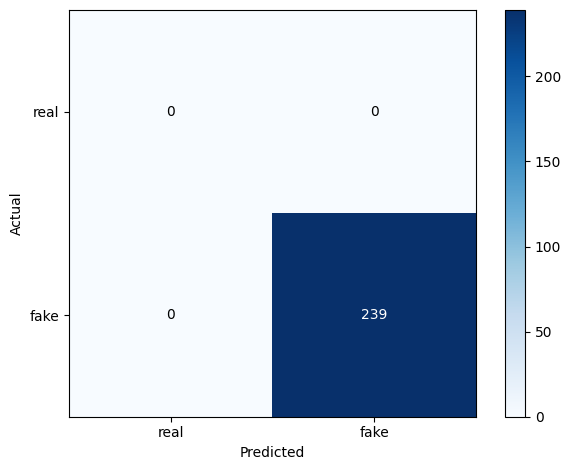

Total Predicted = 239
Predicted real = 103
Predicted fake = 136

Accuracy = 0.5690376569037657


In [19]:
multi_article_test(test_data, real_count, fake_count, pred_labels)